In [62]:
from sklearn import preprocessing
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest, RFE, VarianceThreshold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
import pandas as pd 
import numpy as np 
from numpy import inf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
warnings.filterwarnings("ignore")
%matplotlib inline

In [205]:
def normalize(data_frame, columns):
    """
    Normalizing (loged) column values
    :param data_frame: A pandas DataFrame to be processed
    :param columns: List of column names of categorical variables 
    :returns data_frame: DataFrame with normalizedcolumns
    """    
    for col in columns:
        data_frame[col] = log_colum_values(data_frame[col])
    return data_frame

def log_colum_values(series_col):
    """
    Normalizing (loged) column values
    :param series_col: Column of dataframe 
    :returns np array: DataFrame with normalizedcolumns
    """    
    min_val = series_col.min()
    values = [log_value(v, min_val)for v in series_col.values]
    return values

def log_value(x, min_val):
    """
    Logs a value, replacing -inf with 0 and handling negative values
    :param x: value
    :param min_val: min value in list 
    :returns value: loged numerical value
    """    
    if x>0:
        return np.log(x)
    if np.log(x) == -inf:
        return 0 
    if x < 0:
#         print("na")
        return np.log(x + 1 - min_val)

def preprocess_data_frame(data_frame, columns):
    """
    Dummifying and encoding variables of dataframe, droping rows with NAN values
    :param data_frame: A pandas DataFrame to be processed
    pandas DataFrame
    :param columns: List of column names of categorical variables 
    :returns data_frame: encoded variable DataFrame
    """
    data_frame = data_frame.dropna()
    data_frame = data_frame.reset_index(drop=True)
    
    for col in columns:
#         print(data_frame[col])
        data_frame[col] = encode_variable(data_frame[col])
#         print(data_frame[col])
    data_frame = pd.get_dummies(data_frame)
    return data_frame

def encode_variable(series):
    """
    Encoding categorical variables to numericial values
    :param series: A pandas Series with categorical values
    pandas DataFrame
    :returns data_frame: encoded variable DataFrame
    """
    le = preprocessing.LabelEncoder()
    le.fit(series)
    print(list(le.classes_))
    print(set(le.transform(series))) 
    data_frame = pd.DataFrame({
        series.name: le.transform(series)
    })
    return data_frame

def show_kbest(data_frame, target, linear_rel=True, k=4):
    """
    Selecting K-Best features for classification
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :param k: desired number of features from the data
    :returns feature_scores: scores for each feature in the data as 
    pandas DataFrame
    """
    scores = []
    if linear_rel == True: 
        feat_selector = SelectKBest(f_regression, k=k)
        _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
        col_name = "F Score"
    else:
        feat_selector = SelectKBest(mutual_info_regression, k=k)
        _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
        col_name = "Mutual Information"
    
    feat_scores = pd.DataFrame()
    feat_scores[col_name] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns
    
    return feat_scores 

def get_features_variance_threshold(data_frame,target="gender", threshold=0.2):
    """
    Returns list of features with a variance above the specified threshold
    :param data_frame: A pandas dataFrame with the training data
    :param threshold: float value between 0 and 1 
    :returns feature_scores: list of features
    """
    if target in data_frame.columns:
        data_frame = data_frame.drop([target], axis=1)
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(data_frame)
    # Get the indices of zero variance feats
    feat_ix_keep = selector.get_support(indices=True)
#     print(feat_ix_keep)
    return data_frame.columns[feat_ix_keep]

def get_features_univariate(data_frame, k=5, linear=True, target="gender"):
    """
    Returns list of features selected using the specified univariate method
    :param data_frame: A pandas dataFrame with the training data
    :param k: top k features to select  
    :returns data_frame: with selected features
    """
    df = show_kbest(data_frame,target=target,linear_rel=linear, k=k)
    df = df[df["Support"] == True]
    columns = df["Attribute"].values
    return columns

def get_features_rfe(data_frame,model,k=5):
    """
    Returns list of features (k specified) selected using RFE for
    :param data_frame: A pandas dataFrame with features and labels
    :param k: top k features to select  
    :returns list: most relevant features 
    """
    X = data_frame.drop("gender", axis=1)
    y = data_frame["gender"]
    selector = RFE(model, k, step=1)
    selector = selector.fit(X, y)
#     print(selector.support_)
    df = pd.DataFrame({
        "feature": X.columns,
        "support": selector.support_
    })
    return list(df[df["support"] == True]["feature"])

def split_dataframe(data_frame, target):
    """
    Split dataframe to predictors and target
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :returns DataFrames: X (predictors) and y (target) dataframes 
    """
    X = data_frame.drop([target], axis=1)
    y = pd.DataFrame(data_frame[target], columns=[target])
    return X, y 

def model_score(X,y, model):
    """
    Cross validation scores - R^2,mae,mse...
    :param X: A pandas DataFrame with features
    :param y: A pandas DataFrame with targets 
    :param model: Sklearn estimator object
    :returns tuple: name, r^2, mae, nmsle, mse
    """ 
    r2 = cross_val_score(model, X, y,cv=10,scoring="r2").mean()
    mae = cross_val_score(model, X, y,cv=10,scoring="median_absolute_error").mean()
    msle = cross_val_score(model, X, y,cv=10,scoring="neg_mean_squared_log_error").mean()
    mse = cross_val_score(model, X, y,cv=10,scoring="mean_squared_error").mean()
    return r2,mae,msle,mse
def score_comparison(X,y, model_dict, col_names=["Model","r2","mae","neg msle","mse"]):
    """
    DataFrame with model scores
    :param X: A pandas DataFrame with features
    :param y: A pandas DataFrame with targets
    :param model_dict: Model names are keys, sklearn estimatir objects
    :param col_names: Names of DataFrame columns
    :returns tuple: name, r^2, mae, nmsle, mse
    """ 
    lst = []
    for name,model in model_dict.items():
        r2,mae,msle,mse = model_score(X,y,model)
        lst.append([name,r2,mae,msle,mse])
    return pd.DataFrame(lst, columns=col_names)

def model_coefs(X,y, model_dict):
    """
    Returns a dataframe with coefficients for each of the models
    :param X: A pandas DataFrame with features
    :param y: A pandas DataFrame with targets 
    :param model_dict: Model names are keys, sklearn estimatir objects
    :returns data_frame: DataFrame with coefficients for each of the models
    """ 
    dic  = {}
    for name, model in model_dict.items():
        m = model.fit(X,y)
        try:
            dic[name] = m.coef_.flatten()
        except:
            None
    dic["Attribute"] = X.columns
    
    return pd.DataFrame(dic)

def important_features(X,y, model_dict):
    """
    Returns a dataframe with feature importance scores for each of the models
    :param X: A pandas DataFrame with features
    :param y: A pandas DataFrame with targets 
    :param model_dict: Model names are keys, sklearn estimatir objects
    :returns data_frame: DataFrame with feature importance scores for each of the models
    """ 
    dic  = {}
    for name, model in model_dict.items():
        m = model.fit(X,y)
        try:
            dic[name] = m.feature_importances_
        except:
            None
    dic["Attribute"] = X.columns
    
    return pd.DataFrame(dic)

# Load the data

In [33]:
data = pd.read_pickle("../data/final_sets/countries/model/2016_american")

In [34]:
data = preprocess_data_frame(data,["gender"])

['female', 'male']
{0, 1}


In [35]:
data = normalize(data, ["eig_central","in_degree","k_core","out_degree","efficiency","views"])

In [78]:
X,y = split_dataframe(data,"views")

In [81]:
# X.shape

In [80]:
# y

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)
y_train = pd.DataFrame(y_train, columns=y.columns)
y_test =pd.DataFrame(y_test, columns=y.columns)

In [48]:
# show_kbest(data,target="views",linear_rel=False,k=5)

In [42]:
# get_features_variance_threshold(data,target="views",threshold=0.8)

In [85]:
reg.coef_

array([[ -4.40364074e-01,  -1.46368046e-01,  -1.29604779e-01,
          4.54705771e-03,   5.83621245e-01,  -4.15258152e-01,
          4.78574019e-01,  -5.79311507e-03,   9.08122808e-05,
          6.84393234e-04,  -5.93580751e-04,   6.50980987e-02,
          4.47357181e-03,   9.72223659e-02,  -1.78905780e-01,
         -3.27314441e-01,   5.06220221e-01,   3.47376766e-01,
         -4.45563613e-01,   9.81868475e-02]])

# Views Distribution

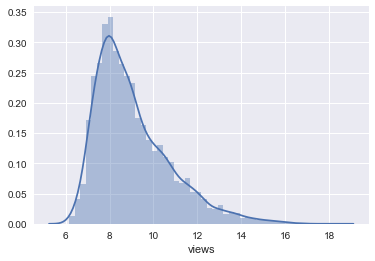

In [117]:
sns.distplot(data["views"])

# Algorithms

In [196]:
#Linear Regression
lin_reg = linear_model.LinearRegression()
#Ridge Regression
ridge = linear_model.Ridge(alpha = .5)
#Lasso Regression
lasso = linear_model.Lasso(alpha = 0.1)
#Decision Tree Regressor
d_tree = DecisionTreeRegressor(random_state=0)
#Random Forest Regressor 
r_forest = RandomForestRegressor(max_depth=2, random_state=0)

In [192]:
model_dict = {
    "Linear Regression":lin_reg,
    "Lasso Regression": lasso,
    "Ridge Regression": ridge,
    "Decision Tree Regressor": d_tree,
    "Random Forest Regressor": r_forest
}

# F-scores

In [108]:
show_kbest(data, "views", linear_rel=True,k=5).drop(["Support"], axis=1)

,F Score,P Value,Attribute
0,40.768458,1.878188e-10,gender
1,1726.354863,6.126414e-322,entered
2,8.583088,3.409219e-03,efficiency
3,309.900189,3.075019e-67,eig_central
4,2624.442720,0.000000e+00,in_degree
5,2031.245617,0.000000e+00,k_core
6,1921.457065,0.000000e+00,out_degree
7,125.785979,7.893756e-29,age
8,2.033988,1.538826e-01,distance_birth
9,12.860952,3.389002e-04,distance_death


# Mutual Information

In [113]:
show_kbest(data, "views", linear_rel=False,k=5).drop(["P Value","Support"], axis=1)

,Mutual Information,Attribute
0,0.004822,gender
1,0.272324,entered
2,0.143457,efficiency
3,0.255782,eig_central
4,0.216257,in_degree
5,0.220694,k_core
6,0.156225,out_degree
7,0.031508,age
8,0.071488,distance_birth
9,0.029211,distance_death


# Model Comparison

In [193]:
score_comparison(X,y,model_dict)

,Model,r2,mae,neg msle,mse
0,Linear Regression,0.485523,-0.727975,-0.012942,-1.413071
1,Lasso Regression,0.431226,-0.781722,-0.014163,-1.563230
2,Ridge Regression,0.485533,-0.725919,-0.012943,-1.412908
3,Decision Tree Regressor,0.235171,-0.791795,-0.019267,-2.099663
4,Random Forest Regressor,0.440422,-0.791664,-0.013837,-1.537328


# Feature Importance

In [202]:
model_coefs(X,y,model_dict)

,Attribute,Lasso Regression,Linear Regression,Ridge Regression
0,gender,-0.000000,-4.251780e-01,-0.440364
1,entered,-0.156473,-1.469195e-01,-0.146368
2,efficiency,-0.000000,-1.354288e-01,-0.129605
3,eig_central,0.005656,4.554804e-03,0.004547
4,in_degree,0.458815,5.843011e-01,0.583621
5,k_core,0.000000,-4.173588e-01,-0.415258
6,out_degree,0.176680,4.789777e-01,0.478574
7,age,0.000000,-5.583885e-03,-0.005793
8,distance_birth,-0.001817,2.515433e+11,0.000091
9,distance_death,-0.000410,-2.515433e+11,0.000684


In [204]:
important_features(X,y,model_dict)

,Attribute,Decision Tree Regressor,Random Forest Regressor
0,gender,0.010948,0.000000
1,entered,0.049975,0.259687
2,efficiency,0.043058,0.000000
3,eig_central,0.112649,0.000000
4,in_degree,0.056489,0.071643
5,k_core,0.171691,0.147809
6,out_degree,0.022864,0.023992
7,age,0.029798,0.000000
8,distance_birth,0.033403,0.000000
9,distance_death,0.026868,0.000000
